<a href="https://colab.research.google.com/github/pyt3r/springboard-package/blob/master/capstone/2_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Colab Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
root = pathlib.Path('/content/drive/MyDrive/home/Research/Springboard/Colab Notebooks')

Mounted at /content/drive


## Imports

Import libraries for machine learning, time series analysis, and evaluation metrics:
- **scikit-learn**: Pipeline, preprocessing, models (Logistic Regression, Random Forest), and metrics
- **TimeSeriesSplit**: Ensures proper time-aware cross-validation (no future data leakage)
- **ARIMA**: Traditional time series forecasting model for comparison

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

## Read Raw Price, Features, and Target

Load the processed data files:
- **OHLC data**: Historical price data (Open, High, Low, Close, Volume)
- **Features**: Engineered technical indicators and features
- **Target**: 3-class classification target (Down, Stationary, Up)

**Load OHLC Data**: Read the processed price data (Open, High, Low, Close, Volume) that was cleaned and saved in the EDA notebook.


In [3]:
Ohlc = pd.read_parquet( root / '1. ohlc.parquet' )
Ohlc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-10,57020.10,58029.98,56419.41,57648.71,57648.71,2.885763e+10
2024-09-11,57650.29,57991.32,55567.34,57343.17,57343.17,3.704906e+10
2024-09-12,57343.17,58534.36,57330.10,58127.01,58127.01,3.383571e+10
2024-09-13,58130.32,60648.02,57650.11,60571.30,60571.30,3.249053e+10
2024-09-14,60569.12,60656.72,59517.88,60005.12,60005.12,1.642841e+10


**Load Features**: Read the engineered features (technical indicators like RSI, MACD, moving averages, etc.) created in the features notebook.


In [4]:
Features = pd.read_parquet( root / '2. features.parquet' )
Features.head()

,ema(30),"x(sma(15),sma(50))","bollUpper(20,2)","bollLower(20,2)","macdDistance(12, 26, 9)",rsiEma(14),mfi(14),atr(14),realized_vol(14),vol_ratio,...,return_1d,return_3d,return_5d,return_10d,momentum_5d,momentum_10d,momentum_20d,price_position(20),dist_from_high(20),dist_from_low(20)
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-22,82604.411908,1.0,104231.402465,64963.117535,971.784014,85.764364,88.450118,4209.416429,0.537691,1.407752,...,0.005004,0.072055,0.101861,0.125539,0.101861,0.125539,0.428759,1.000000,0.000000,0.459895
2024-11-23,83589.934731,1.0,105029.743415,67068.392585,800.507075,78.388066,84.555442,4253.902857,0.550372,1.424490,...,-0.012327,0.036441,0.079903,0.079408,0.079903,0.079408,0.422399,0.960868,-0.012327,0.441898
2024-11-24,84526.399811,1.0,105188.115929,69930.251071,610.002580,78.795923,79.477909,4107.482143,0.535772,1.372835,...,0.002419,-0.004984,0.061401,0.123362,0.061401,0.123362,0.445386,0.966805,-0.009938,0.413126
2024-11-25,85082.959416,1.0,104289.235204,73203.405796,88.327747,54.261891,71.404118,3891.115714,0.433320,1.104937,...,-0.050110,-0.059550,-0.013114,0.022361,-0.013114,0.022361,0.342314,0.747615,-0.059550,0.230876
2024-11-26,85530.738448,1.0,103874.811967,75252.453033,-372.215541,50.163352,61.819462,3849.627857,0.435544,1.103329,...,-0.011997,-0.059236,-0.066184,0.015756,-0.066184,0.015756,0.216108,0.696341,-0.070833,0.211850


**Load Target**: Read the 3-class target variable:
- **Class 0**: Down (price decrease ≤ -1%)
- **Class 1**: Stationary (price change between -1% and +1%)
- **Class 2**: Up (price increase ≥ +1%)

The `squeeze()` method converts the DataFrame to a Series for easier manipulation.


In [5]:
Target = pd.read_parquet( root / '2. target.parquet' )
Target = Target.squeeze()
Target.head()

,Target
Date,
2024-11-22,0
2024-11-23,1
2024-11-24,0
2024-11-25,0
2024-11-26,2


**Data Quality Check**: Verify data integrity and examine class distribution. This is critical because:
1. **Class imbalance** can bias models toward the majority class
2. **Missing values** need to be handled before training
3. **Data alignment** ensures features and targets match

**Interpretation**: The output shows:
- Number of samples (292)
- Confirmation of no missing values
- Class distribution showing whether the dataset is balanced
- Class percentages help identify if we need class weighting


In [6]:
print( len(Features), len(Target) )
print( Features.isnull().sum().sum(), Target.isnull().sum() )

print( '\nTarget class distribution (3-class):' )
print( '0 = Down (<= -1%), 1 = Stationary (-1% to +1%), 2 = Up (>= +1%)' )
print( Target.value_counts().sort_index() )
print( '\nClass percentages:' )
print( (Target.value_counts().sort_index() / len(Target) * 100).round(2) )

292 292
0 0

Target class distribution (3-class):
0 = Down (<= -1%), 1 = Stationary (-1% to +1%), 2 = Up (>= +1%)
Target
0     79
1    133
2     80
Name: count, dtype: int64

Class percentages:
Target
0    27.05
1    45.55
2    27.40
Name: count, dtype: float64


In [7]:
def crossValidate( features, target, pipeline, getImportances, n_splits=5 ):

    metrics = []
    importances = []

    X = features.values
    y = target.values
    tscv = TimeSeriesSplit( n_splits=n_splits )
    for trainIdx, testIdx in tscv.split(X):

        pipeline.fit(X[trainIdx], y[trainIdx])

        y_pred  = pipeline.predict(X[testIdx])
        y_proba = pipeline.predict_proba(X[testIdx])

        # Use 'ovr' (one-vs-rest) or 'ovo' (one-vs-one) strategy
        try:
            roc_auc = roc_auc_score( y[testIdx], y_proba, multi_class='ovr', average='weighted' )
        except:
            roc_auc = np.nan

        metrics.append({
            'roc_auc'  : roc_auc,
            'accuracy' : accuracy_score( y[testIdx], y_pred ),
            'f1_weighted' : f1_score( y[testIdx], y_pred, average='weighted' ),
            'f1_macro'    : f1_score( y[testIdx], y_pred, average='macro' ),
        })

        clf = pipeline.named_steps["classifier"]
        importances.append( getImportances( clf, features ) )

    return pd.DataFrame( metrics ), pd.DataFrame( importances ).T


**Cross-Validation Function**: This function implements proper time series cross-validation:

1. **TimeSeriesSplit**: Ensures training data always comes before test data (no future leakage)
2. **Metrics Calculated**:
   - **ROC-AUC**: Area under ROC curve (uses probabilities, multi-class with 'ovr' strategy)
   - **Accuracy**: Overall classification accuracy (uses class predictions)
   - **F1-Score (weighted)**: Accounts for class imbalance
   - **F1-Score (macro)**: Equal weight to each class
3. **Feature Importances**: Tracks which features are most important for each fold

**Key Point**: For 3-class classification, we use `multi_class='ovr'` (one-vs-rest) for ROC-AUC, which treats each class against all others.


## Logistic Regression

**Logistic Regression Pipeline**: Creates a scikit-learn pipeline with:
1. **StandardScaler**: Normalizes features to have zero mean and unit variance (important for logistic regression)
2. **LogisticRegression**: Linear classifier with multinomial loss for 3-class classification

**Configuration**:
- `solver='lbfgs'`: Supports multinomial (multi-class) regression
- `multi_class='multinomial'`: Explicitly handles 3 classes
- `max_iter=2000`: Allows sufficient iterations for convergence


In [8]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(
        solver       = 'lbfgs',        # 'liblinear' (binary only) to 'lbfgs' (supports multinomial)
        multi_class  = 'multinomial',  # Explicitly use multinomial for 3-class
        max_iter     = 2000,
        random_state = 42,
    ))
])

In [9]:
def getImportances( clf, Features ):
    coef_avg = np.abs(clf.coef_).mean(axis=0)
    return dict( zip( Features.columns, coef_avg ))

metrics, importances = crossValidate( Features, Target, pipeline, getImportances, n_splits=5 )
print("Logistic Regression Metrics:")
print(metrics.mean())
print("\nTarget class distribution:")
print(Target.value_counts().sort_index())

Logistic Regression Metrics:
roc_auc        0.536061
accuracy       0.429167
f1_weighted    0.348410
f1_macro       0.288982
dtype: float64

Target class distribution:
Target
0     79
1    133
2     80
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

**Feature Importances**: For multi-class logistic regression, coefficients are shape `(n_classes, n_features)`. We average the absolute values across classes to get overall feature importance.

**Interpretation of Results**:
- **ROC-AUC ~0.54**: Barely better than random (0.5), indicating weak predictive power
- **Accuracy ~0.43**: Only slightly better than random guessing (33% for 3-class)
- **F1-Scores**: Low values indicate poor precision and recall
- These metrics suggest the model struggles to distinguish between classes, likely due to noisy target or insufficient features


In [10]:
importances.mean(1).abs().sort_values( ascending=False )

,0
vol_ratio,0.420383
obv_ma(20),0.409533
obv,0.409016
price_position(20),0.404716
"macdDistance(12, 26, 9)",0.347008
dist_from_high(20),0.332706
atr(14),0.323130
dist_from_low(20),0.274139
realized_vol(14),0.258818
rsiEma(14),0.233140


## Random Forest

**Random Forest Pipeline**: Random Forest is an ensemble method that:
1. Builds multiple decision trees on random subsets of data
2. Averages predictions across trees (reduces overfitting)
3. Doesn't require feature scaling (tree-based method)

**Configuration**:
- `n_estimators=50`: Number of trees in the forest
- `class_weight='balanced'`: Automatically adjusts weights to handle class imbalance
- `criterion='gini'`: Splitting criterion for trees


In [11]:
pipeline = Pipeline(steps=[
    ("classifier", RandomForestClassifier(
        n_estimators = 50,
        criterion   = 'gini',
        class_weight = 'balanced',  # Handle class imbalance
        random_state = 42,  # For reproducibility
    ))
])


## Train Baselines

In [12]:
def getImportances( clf, Features ):
    return dict(zip( Features.columns, clf.feature_importances_ ))

metrics, importances = crossValidate( Features, Target, pipeline, getImportances, n_splits=5 )
print("Random Forest Metrics:")
print(metrics.mean())
print("\nTarget class distribution:")
print(Target.value_counts().sort_index())

Random Forest Metrics:
roc_auc        0.518330
accuracy       0.337500
f1_weighted    0.286332
f1_macro       0.275682
dtype: float64

Target class distribution:
Target
0     79
1    133
2     80
Name: count, dtype: int64


**Interpretation of Results**:
- **ROC-AUC ~0.52**: Worse than logistic regression, barely above random
- **Accuracy ~0.34**: Worse than random guessing (33%), indicating the model may be overfitting or the problem is very difficult
- **F1-Scores**: Very low, suggesting poor class separation
- Random Forest's poor performance on this small dataset suggests we may need more data, better features, or simpler models


In [13]:
importances.mean(1).abs().sort_values( ascending=False )

,0
obv,0.067511
return_1d,0.050133
volume_ratio,0.049902
ema(30),0.048857
mfi(14),0.048571
atr(14),0.047053
"bollUpper(20,2)",0.045943
return_10d,0.043901
"bollLower(20,2)",0.043803
"macdDistance(12, 26, 9)",0.043400


## ARIMA

**ARIMA Model**: ARIMA (AutoRegressive Integrated Moving Average) is a traditional time series forecasting model that:
1. Uses only historical price data (no features)
2. Models trends and seasonality in the time series
3. Makes point forecasts (predicts actual price, not direction)

**Configuration**:
- `order=(2,2,0)`: AR(2) with differencing of order 2, no MA component
- **Rolling Window**: Uses a sliding window of 25% of data for training
- **Rolling Forecasts**: Retrains the model for each new prediction using only past data


In [14]:
window = int( len( Ohlc )*0.25 ) # sliding window of history to use in the model

X, y = Ohlc.iloc[ 0:window ]['Close'], Ohlc.iloc[ window: ]['Close']

history = X.tolist()

# make first prediction
preds = [None]
model = ARIMA( history, order=(2,2,0) )
model_fit = model.fit()
pred = model_fit.forecast()[0]
preds.append( pred )
history.append( y.iloc[0] )

# rolling forecasts
for i in range( 1, len(y) ):
    model = ARIMA( history[-window:], order=(2,2,0) )
    model_fit = model.fit()
    pred = model_fit.forecast()[0]
    preds.append( pred )
    history.append( y.iloc[i] )

preds = pd.Series( preds[:-1], index=y.index )

**ARIMA Visualization**: Plot shows:
- **Green**: Training data (historical prices used to fit the model)
- **Red**: Actual future prices (ground truth)
- **Blue**: Predicted prices from ARIMA

This visualization helps assess whether ARIMA captures price trends and patterns. If predictions closely follow actual prices, the model may have predictive value.


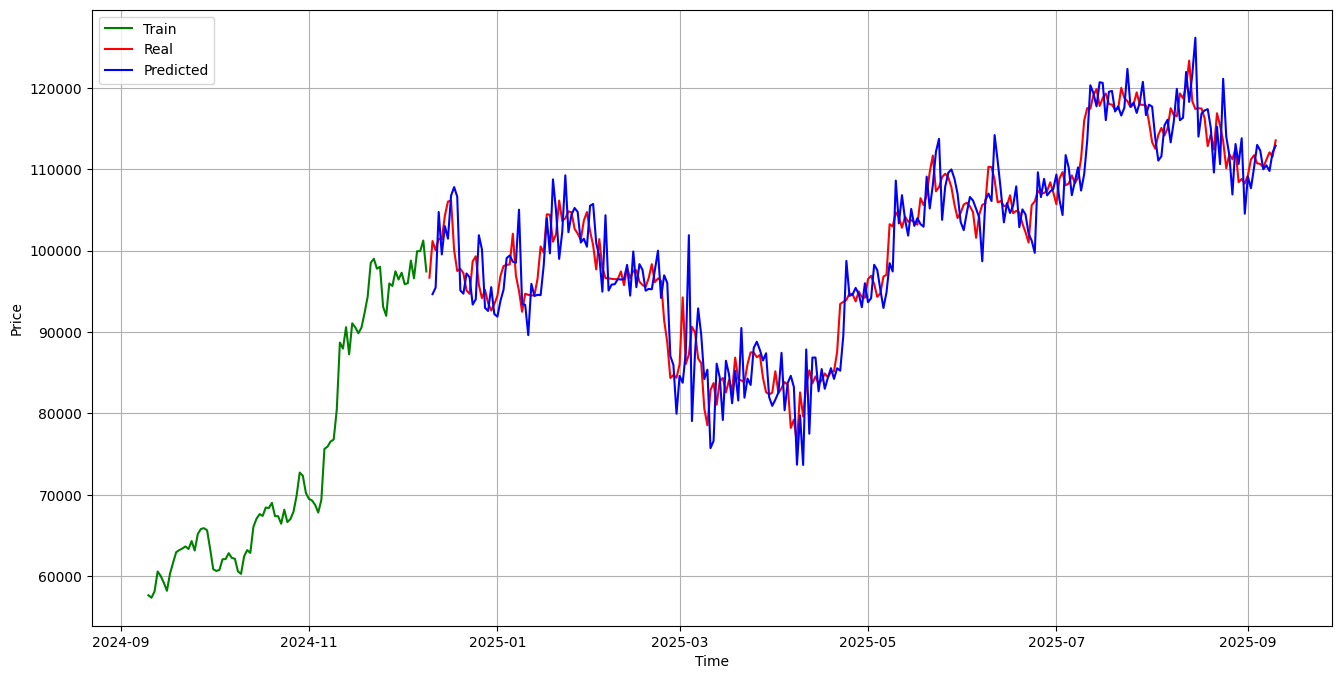

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(Ohlc['Close'].iloc[:window], color='green', label = 'Train')
plt.plot(y, color = 'red', label = 'Real')
plt.plot(preds, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate the Direction Predicted by ARIMA

In [16]:
def convert_to_3class(predicted_prices, actual_current_prices, up_threshold=0.01, down_threshold=-0.01):
    """ Convert price predictions to 3-class target using same thresholds as target definition. """
    # Calculate predicted return: (predicted_next_price - actual_current_price) / actual_current_price
    returns = (predicted_prices - actual_current_prices) / actual_current_prices

    # Initialize as stationary (class 1)
    target = pd.Series(1, index=predicted_prices.index, dtype=int)

    # Mark significant moves
    target[returns >= up_threshold] = 2  # Up (>= 1%)
    target[returns <= down_threshold] = 0  # Down (<= -1%)

    return target

# Get current prices (day before predictions) to calculate returns
# preds predicts y (next day prices), so we need prices from day before y
current_prices = Ohlc['Close'].iloc[window-1:window-1+len(y)]
predTarget = convert_to_3class(preds, current_prices, up_threshold=0.01, down_threshold=-0.01)

In [17]:
index = predTarget.index.intersection( Target.index )

target     = Target.loc[ index ]
predTarget = predTarget.loc[ index ]

print( 'Accuracy:', accuracy_score( target, predTarget ))
print( 'F1 (weighted):', f1_score( target, predTarget, average='weighted' ))
print( 'F1 (macro):', f1_score( target, predTarget, average='macro' ))
print( '\nClassification Report:')
print( classification_report( target, predTarget, target_names=['Down', 'Stationary', 'Up'] ))
print( '\nConfusion Matrix:')
print( confusion_matrix( target, predTarget ))


Accuracy: 0.3467153284671533
F1 (weighted): 0.3380567238088186
F1 (macro): 0.34620366702860067

Classification Report:
              precision    recall  f1-score   support

        Down       0.32      0.51      0.39        72
  Stationary       0.50      0.22      0.31       127
          Up       0.29      0.40      0.34        75

    accuracy                           0.35       274
   macro avg       0.37      0.38      0.35       274
weighted avg       0.40      0.35      0.34       274


Confusion Matrix:
[[37 13 22]
 [49 28 50]
 [30 15 30]]


**Convert ARIMA Predictions to 3-Class Target**: Since ARIMA predicts prices (continuous values) but we need direction (3 classes), we:
1. Calculate predicted returns: `(predicted_price - current_price) / current_price`
2. Convert to 3-class using the same thresholds as the target definition:
   - Down (≤ -1%): Class 0
   - Stationary (-1% to +1%): Class 1
   - Up (≥ +1%): Class 2

**Interpretation of Results**:
- **Accuracy ~0.35**: Slightly better than random (33%), but still poor
- **F1-Scores**: Low precision and recall across all classes
- **Confusion Matrix**: Shows where the model makes mistakes:
  - Stationary class (class 1) has the most samples but lowest recall (22%), meaning the model struggles to identify stationary periods
  - Down and Up classes have moderate recall but low precision, indicating many false positives
- ARIMA's poor performance suggests price direction is difficult to predict from price history alone
